# Prediction of Hospital Readmission with Machine Learning Models

### Fumei Lin   12/8/2019

## Introduction
The objectives of this project is to use machine learning modeling to predict which patients are more likely to be readmitted to the hospital within 30 days of a discharge. If readmissions can be accurately predicted, health care providers will be able to attempt to change and improve on the process of care, to eventually reduce the readmission episodes. Therefore, this analysis has the potentials to improve the quality and reduce the total cost of patient care.

Two different models, Logistic Regression and Random Forest Classifier, will be used and the results will be compared. The data used in this project is the MIMIC-III public data set. Some data processing is needed in order to prepare the original CSV data files ready for the modeling, which I will not describe in detail here. The outcome to be predicted is a dichotomy variable, of whether the patient was readmitted within 30 days of a discharge. The predictor features added to the model include demographic, diagnosis codes, procedures, and many other measurable features related to hospital encounters which I consider relevant.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# load data files 
df_demDx = pd.read_csv('SummaryWithDx.csv')
df_pxc = pd.read_csv('Px3ICD9.csv')
df_icu = pd.read_csv('ICUSTAYS.csv')

# pivot the long records into wide format, bsically onehot encoding to turn categorical variables into dichotomy ones
df_pxc["val"] = 1
px = pd.pivot_table(df_pxc, index=["HADM_ID"],columns = ["proc_code"], 
                    values=["val"], aggfunc=[np.sum], fill_value=0)

icu = pd.pivot_table(df_icu, index=["HADM_ID"],columns = ["LAST_CAREUNIT"], 
                    values=["LOS"], aggfunc=[np.sum], fill_value=0)

# join 3 data sets together
df_1 = df_demDx.merge(px, left_on='HADM_ID', right_on='HADM_ID', how='inner')
df_data = df_1.merge(icu, left_on='HADM_ID', right_on='HADM_ID', how='inner')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 3 on the right)
  warnings.warn(msg, UserWarning)


As expected, age distrubution is schewed towards older patients. So instead of using the continuous age variable, a recoded ordinal ageGroup is used in the model.  

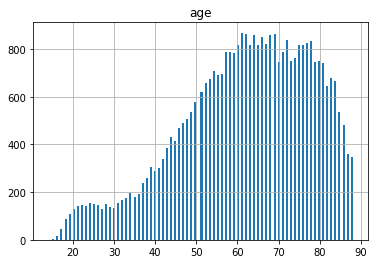

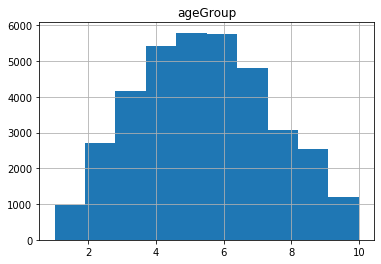

In [2]:
# data cleaning
# include only if age >0 and < 120 , exclude about 2350 cases
df_data = df_data[(df_data.age > 0) & (df_data.age < 120)]

# age is schewed, not normal distribution
df_data.hist(column='age', bins=150)

# recode age as ordinal ageGroup
df_data.loc[(df_data.age <25), 'ageGroup'] = 1
df_data.loc[(df_data.age >=25) & (df_data.age <40), 'ageGroup'] = 2
df_data.loc[(df_data.age >=40) & (df_data.age <50), 'ageGroup'] = 3
df_data.loc[(df_data.age >=50) & (df_data.age <58), 'ageGroup'] = 4
df_data.loc[(df_data.age >=58) & (df_data.age <65), 'ageGroup'] = 5
df_data.loc[(df_data.age >=65) & (df_data.age <72), 'ageGroup'] = 6
df_data.loc[(df_data.age >=72) & (df_data.age <78), 'ageGroup'] = 7
df_data.loc[(df_data.age >=78) & (df_data.age <82), 'ageGroup'] = 8
df_data.loc[(df_data.age >=82) & (df_data.age <86), 'ageGroup'] = 9
df_data.loc[(df_data.age >=86), 'ageGroup'] = 10

df_data.hist(column='ageGroup')

# 1 = axis number, 0 for rows and 1 for columns
df_data = df_data.drop('age', 1)

Data transformation and cleaning are completed. Now the data is ready for the modeling. The data is split into 3 sets: 80% for the training set, 10% for the validation set, the other 10% will be used as the final test data set.  

In [3]:
# set 20% of data for validation/test 
df_valid_test = df_data.sample(frac = 0.20,random_state = 42)
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# the other 80% as training data
df_train_all = df_data.drop(df_valid_test.index)

 Stop and run some checking here, to make sure data rows and columns are as intended in all sets. 

In [4]:
# check data (rows, columns)
print(df_train_all.shape)
print(df_valid.shape)  
print(df_test.shape)

# check the average readmission rate in all sets
print(df_train_all.Readmit30D.mean())   
print(df_valid.Readmit30D.mean())   
print(df_test.Readmit30D.mean())

(29142, 478)
(3643, 478)
(3643, 478)
0.04629057717383844
0.049135328026351906
0.04474334339829811


We do not expect the overall readmission rate to be very high. And that is proved by the return values of Readmit30D.mean(), under 5%. Here the positive:negative ratios are about 1:20. Such an extremely unbalanced data set is not ideal for training, since the model can just assign a negative outcome to every case, and it would be correct 95% of times. To solve this problem, the training data set need to adjusted to be more balanced. The approach taken here is to under sample the negative cases, so as to raise the positive:negative ratio to 1:3. 

In [5]:
# balance the training data
# first split train data into positive/negative 
rows_pos = df_train_all.Readmit30D == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]
# merge the balanced data, with positive:negative ratio = 1:3
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = 3 * len(df_train_pos), random_state = 42)],axis = 0)
# shuffle the order of train data 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

The data is now ready for the models. The outcome variables and predicting feature data sets are defined.

In [6]:
# the outcome variables
y_train = df_train.Readmit30D
y_valid = df_valid.Readmit30D
y_test = df_test.Readmit30D

# turns df to numy arry
x_train = df_train.to_numpy()
x_valid = df_valid.to_numpy()

# skip 2 columns( HADM_ID, readmit30D)
x_train_tf = x_train[:,2:]
x_valid_tf = x_valid[:,2:]

# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(bootstrap=False, n_jobs=2, 
                             min_samples_leaf=5, min_samples_split=10 , 
                             random_state=20, max_features= 80, 
                             n_estimators=50)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(x_train_tf, y_train)

# calculate probability of readmission for each sample with the model
# Using [:,1] here gives the probabilities of getting output as 1. 
model = clf 
y_train_preds = model.predict_proba(x_train_tf)[:,1] 
y_valid_preds = model.predict_proba(x_valid_tf)[:,1]

The random Forest Classifier model is configured, and we supply the training data so the model can learn about the relationship between the features and the outcome, and come up with the best fit model for prediction. When the learning is not, we feed the output to the model to check how the model predict in all cases. Each case will get a probability between 0 and 1. With these probability values, we will check how accurate the model predicts.

In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

Prediction of a dichotomy outcome always involves tradeoffs. Simply put, if the most stringent crteria is applied, it will call out more accurate cases (true positive), but it will also call out more false postive cases and lose specificity. Here is a plot of ROC (receiver operating characteristic) curves to illustrate the relationship between these two types of prediction results.

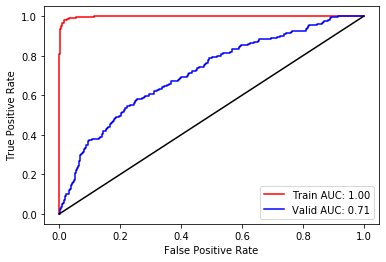

In [8]:
# plot ROC curves
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

To evaluate the overall quality of the prediction, i.e. how well the model performs, we need to define a matrix or index. Here, I've decided to use the computed area under ROC Curve (AUC), and the AUC value for the validation set is 0.71. That may not seem to be very impressive prediction power, yet it's very close to other published results using the same data set. So I am going to leave the model as is for now, and apply the model to the Test data set. The AUC for the Test set turns out to be 0.748, slightly better than the validation set. 

In [9]:
x_test = df_test.to_numpy()
x_test_tf = x_test[:,2:]

y_test_preds = model.predict_proba(x_test_tf)[:,1]

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Test AUC:%.3f'%auc_test) 

Test AUC:0.748



## Logistic Regression Model
judging from the AUC values, apparently there is still room for improvement in the modeling. So I am curious to see how a diffeent model will perform using the exact same feature sets. I will now feed the same data to a Logistic Regression classifier model for training, and compare that result to the Random Forest Classifier model.

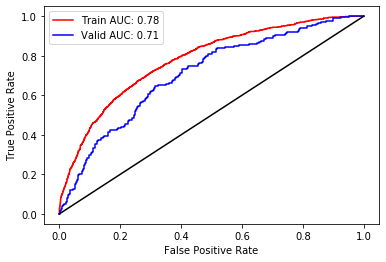

In [10]:
### build a model with logistic regression 
from sklearn.linear_model import LogisticRegression

# apply logistic Regression 
# to build a model to predict Y from x, outcome from train data matrix
clf = LogisticRegression(C = 0.5, penalty = 'l2', random_state = 42, max_iter = 1200, solver = 'lbfgs') 

# Train the LR Classifier model
clf.fit(x_train_tf, y_train)

# calculate probability of readmission for each sample with the model
# Using [:,1] here gives the probabilities of getting output as 1. 
model = clf 
y_train_preds = model.predict_proba(x_train_tf)[:,1] 
y_valid_preds = model.predict_proba(x_valid_tf)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

# plot ROC curves
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [11]:
y_test_preds = model.predict_proba(x_test_tf)[:,1]

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)
print('Test AUC:%.3f'%auc_test) 

Test AUC:0.726


Interestingly, with Logistic Regression, the AUC value for the validation set turns out to be exactly the same as derived from the Random Forest Classifier model (0.71). However the final models from both algorithms are not the same becasue the ROC curves for the validation set are not identical in these two models. The AUC value for the test data set is 0.726, slightly lower than the Random Forest Classifier model.

## Conclusions
Random Forest Classifier is a decision-tree based machine learning model, and I have expected it to be a very good model in predicting a dichotomy outcome with a set of discrete value features. The results of this analysis does suggest that it performs slightly better than the Logistic Regression Model. The AUC value for the training set in the Random Forest model is a perfect 1.0, which indicates overfitting. Therefore, if I am to continue with this project, I will first try to corret for the overfitting in the Random Forest model, and see if that improves the prediction in the validation set. I will also examine the features to see which are more important in this prediction model. That may provide some insights as to whether I should add certain other features to the model.